| | |
| --- | --- |
| **Author** | Pierre Alexander Burger |
| **email** | pburger@uwatelroo.ca |

---
---
# **INTRODUCTION**
---
---

### In this notebook, we will train a neural network emulator based on JAX on the $\langle \mathcal{M}^2_\mathrm{ap}\rangle$ and $\langle \mathcal{M}^3_\mathrm{ap}\rangle$ described in Burger et al (2025).

### We will start with a few imports.

In [1]:
import jax.numpy as jnp
import jax
from jax.scipy.linalg import cho_solve, cho_factor
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
import gdown

import blackjax # https://blackjax-devs.github.io/blackjax/

### We first need to download the data for the training.

In [68]:
gdown.download(id='1nBU-x5tAhddjuO-Q_gPpln5jEUprpGjD',output='outputs/Map2_models.npy')
gdown.download(id='1FIPOaEPyvveXKZIdnFEbgV12nTnF-1T7',output='outputs/Map3_models.npy')
gdown.download(id='1nq3G9YrhE1GlabsiK0_-isBkBrxBzxtd',output='outputs/parameters.npy')


Downloading...
From: https://drive.google.com/uc?id=1nBU-x5tAhddjuO-Q_gPpln5jEUprpGjD
To: /Users/pierreburger/GitHub/cosmoemuJAX/outputs/Map2_models.npy
100%|██████████| 88.1k/88.1k [00:00<00:00, 1.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FIPOaEPyvveXKZIdnFEbgV12nTnF-1T7
To: /Users/pierreburger/GitHub/cosmoemuJAX/outputs/Map3_models.npy
100%|██████████| 616k/616k [00:00<00:00, 3.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nq3G9YrhE1GlabsiK0_-isBkBrxBzxtd
To: /Users/pierreburger/GitHub/cosmoemuJAX/outputs/parameters.npy
100%|██████████| 142k/142k [00:00<00:00, 2.08MB/s]


'outputs/parameters.npy'

### Next we inspect the models and paramters

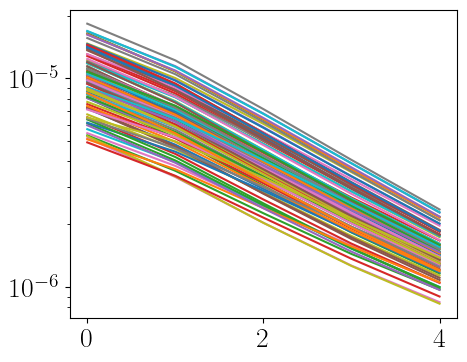

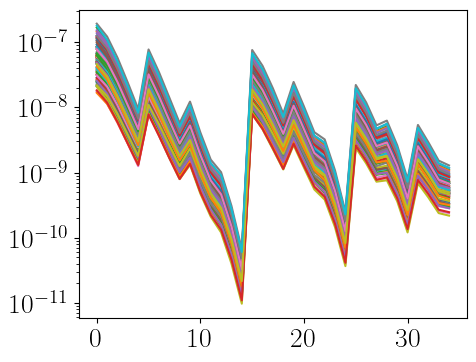

In [69]:
para_names = np.load('outputs/parameters.npy')['para_names']
parameters = np.load('outputs/parameters.npy')['samples']
Map2_models = np.load('outputs/Map2_models.npy')
Map3_models = np.load('outputs/Map3_models.npy')

for i in range(100):
    plt.plot(Map2_models[i])
plt.yscale('log')
plt.show()

for i in range(100):
    plt.plot(Map3_models[i])
plt.yscale('log')
plt.show()

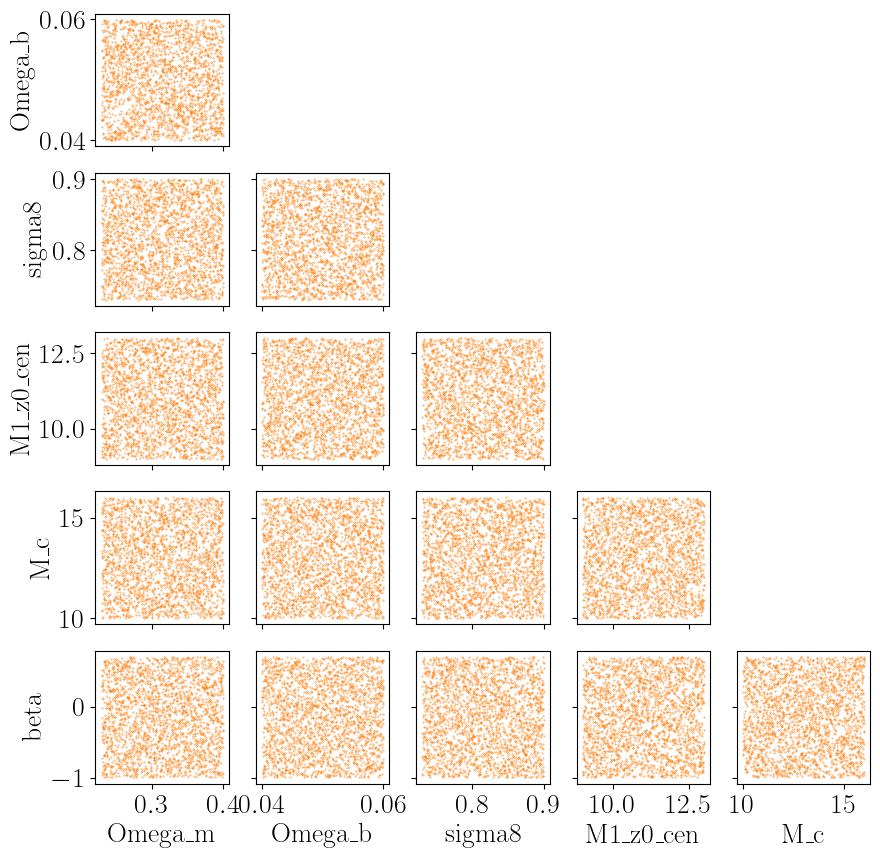

In [70]:


fig, axes = plt.subplots(figsize=(10, 10),ncols=5, nrows=5)

for i in range(5):
    for j in range(5):
    
        if(i<=j):
            
            axes[j,i].scatter(parameters[:,i], parameters[:,j+1],s=0.1,c='C1')
        
            axes[j,i].set_xlabel(para_names[i],size=20)
            axes[j,i].set_ylabel(para_names[j+1],size=20)
        else:
            axes[j, i].axis('off')
for ax in axes.flat:
    ax.label_outer()
plt.show()

### Lets split the data in training and testing

In [5]:
train_sample = np.arange(0,2000)
test_sample = np.arange(2000,2200)

train_params = {}
for i, name in enumerate(para_names):
    train_params[name]=jnp.array(parameters[:,i])[train_sample]
    
test_params = {}
for i, name in enumerate(para_names):
    test_params[name]= jnp.array(parameters[:,i])[test_sample]

Map2_models_train_features = jnp.array(np.log10(Map2_models[train_sample]))
Map2_models_test_features = jnp.array(Map2_models[test_sample])

Map3_models_train_features = jnp.array(np.log10(Map3_models[train_sample]))
Map3_models_test_features = jnp.array(Map3_models[test_sample])

### Next, we train the $\langle \mathcal{M}^2_\mathrm{ap}\rangle$ emaultor with a decreasing learning rate, and no dropout

In [71]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=Map2_models_train_features,

    normalise_mode='mean_sigma', # determines thw way the input and out features are normalised

    learning_rate=1e-2,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[32] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=100,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=500,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=True,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    dropout_rate=0.0,
    random_seed=1,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/Map2_env',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.


  0%|          | 0/10000 [00:00<?, ?it/s]

 17%|█▋        | 1675/10000 [02:04<10:21, 13.40it/s, learning_rate=0.001, train_loss=0.0038711627, validation_loss=0.0063757906]

Epoch 1672: Reducing learning rate to 1.00e-03


 26%|██▌       | 2559/10000 [03:10<09:18, 13.33it/s, learning_rate=0.0001, train_loss=0.0025192648, validation_loss=0.0056431866]

Epoch 2557: Reducing learning rate to 1.00e-04


 31%|███       | 3059/10000 [03:47<08:31, 13.57it/s, learning_rate=1e-5, train_loss=0.0025476876, validation_loss=0.0054010036]  

Epoch 3057: Reducing learning rate to 1.00e-05


 36%|███▌      | 3559/10000 [04:24<07:43, 13.90it/s, learning_rate=1e-6, train_loss=0.0027215176, validation_loss=0.0052975854]

Epoch 3557: Reducing learning rate to 1.00e-06


 41%|████      | 4061/10000 [05:01<07:15, 13.65it/s, learning_rate=1e-6, train_loss=0.0026732683, validation_loss=0.00530837]  

Epoch 4059: Reducing learning rate to 1.00e-06


 46%|████▌     | 4559/10000 [05:38<06:43, 13.49it/s, learning_rate=1e-6, train_loss=0.0024658178, validation_loss=0.0055734417]


Epoch 4559: Learning rate already at minimum 1e-06
Training complete. Best val loss: 0.005298. Model saved to outputs/Map2_env


### Let's investigate the loss and accuracy.

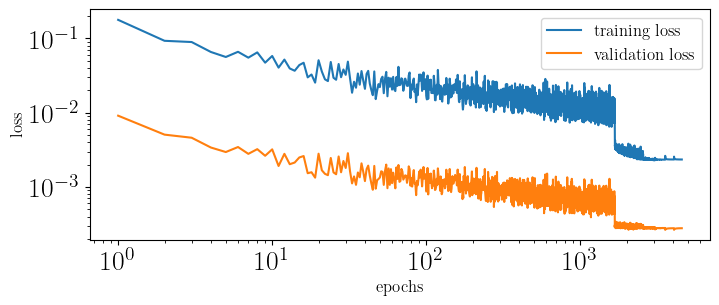

In [72]:
emulator_data = np.load('outputs/Map2_env.npz')
plt.figure(figsize=(8,3))
plt.plot(np.arange(1,len(emulator_data['train_loss'])+1),emulator_data['train_loss']*0.95,label='training loss')
plt.plot(np.arange(1,len(emulator_data['val_losses'])+1),emulator_data['val_losses']*0.05,label='validation loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epochs',size=12)
plt.ylabel('loss',size=12)
plt.legend(fontsize=12)

Loading model from outputs/Map2_env.npz
Loaded keys: KeysView(NpzFile 'outputs/Map2_env.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


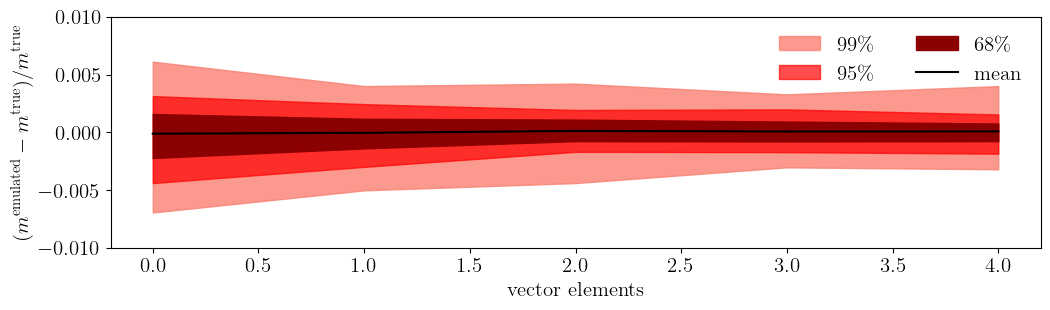

In [73]:
jax_nn = EmulatorJAX(filepath=f'outputs/Map2_env.npz')
emulated_features = jax_nn.ten_to_rescaled_predict(test_params)

diff=(emulated_features/Map2_models_test_features-1) # Measure the relative difference between test sample and the emulated models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = r'$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = r'$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = r'$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.01,0.01)
plt.show()

### Now we do the same for the  $\langle \mathcal{M}^3_\mathrm{ap}\rangle$ emulator.

In [74]:
# === Train Emulator ===
from cosmoemu_jax import EmulatorJAX
jax_nn = EmulatorJAX(verbose=True)
jax_nn.train(
    parameters=para_names,
    raw_training_parameters=train_params,
    raw_training_features=Map3_models_train_features,

    normalise_mode='mean_sigma', # determines thw way the input and out features are normalised

    learning_rate=1e-2,         # Initial learning rate for the optimizer
    epochs=10000,               # Maximum number of training epochs
    n_hidden=[32] * 4,          # Architecture: 4 hidden layers, each with 32 neurons
    batch_size=100,            # Mini-batch size for training

    validation_split=0.05,      # Fraction of training data reserved for validation
    patience=1000,               # Number of epochs to wait before early stopping or reducing learning rate (if no improvement)

    update_lr=True,            # If True: reduce learning rate after patience epochs without improvement
    lr_decay=0.1,               # Factor by which to reduce learning rate (if update_lr is True)
    min_lr=1e-6,                # Minimum learning rate before triggering early stopping

    random_seed=1,              # Seed for reproducibility (weight initialization & data split)
    save_fn='outputs/Map3_env',  # File path to save the trained model
)

Training with 1900 samples and 100 validation samples.


 33%|███▎      | 3309/10000 [04:11<08:23, 13.28it/s, learning_rate=0.001, train_loss=0.006415031, validation_loss=0.0105578685]

Epoch 3307: Reducing learning rate to 1.00e-03


 43%|████▎     | 4309/10000 [05:26<07:08, 13.29it/s, learning_rate=0.0001, train_loss=0.006926474, validation_loss=0.009730095] 

Epoch 4307: Reducing learning rate to 1.00e-04


 53%|█████▎    | 5313/10000 [06:42<06:03, 12.89it/s, learning_rate=1e-5, train_loss=0.006650133, validation_loss=0.009636271]    

Epoch 5310: Reducing learning rate to 1.00e-05


 63%|██████▎   | 6313/10000 [07:58<04:35, 13.40it/s, learning_rate=1e-6, train_loss=0.006682743, validation_loss=0.009617797]  

Epoch 6310: Reducing learning rate to 1.00e-06


 73%|███████▎  | 7313/10000 [09:14<03:36, 12.44it/s, learning_rate=1e-6, train_loss=0.0066824234, validation_loss=0.009620505] 

Epoch 7310: Reducing learning rate to 1.00e-06


 83%|████████▎ | 8310/10000 [10:30<02:08, 13.18it/s, learning_rate=1e-6, train_loss=0.006137275, validation_loss=0.010272194]  


Epoch 8310: Learning rate already at minimum 1e-06
Training complete. Best val loss: 0.009596. Model saved to outputs/Map3_env


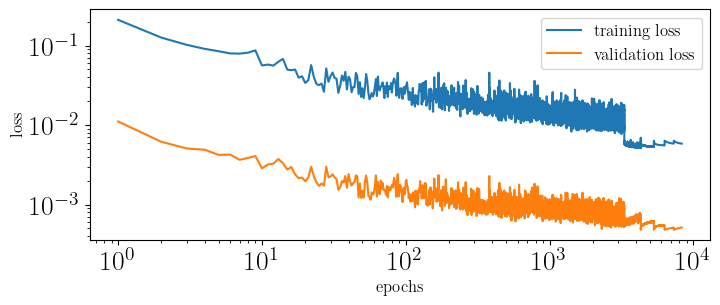

In [75]:
emulator_data = np.load('outputs/Map3_env.npz')
plt.figure(figsize=(8,3))
plt.plot(np.arange(1,len(emulator_data['train_loss'])+1),emulator_data['train_loss']*0.95,label='training loss')
plt.plot(np.arange(1,len(emulator_data['val_losses'])+1),emulator_data['val_losses']*0.05,label='validation loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epochs',size=12)
plt.ylabel('loss',size=12)
plt.legend(fontsize=12)

Loading model from outputs/Map3_env.npz
Loaded keys: KeysView(NpzFile 'outputs/Map3_env.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)


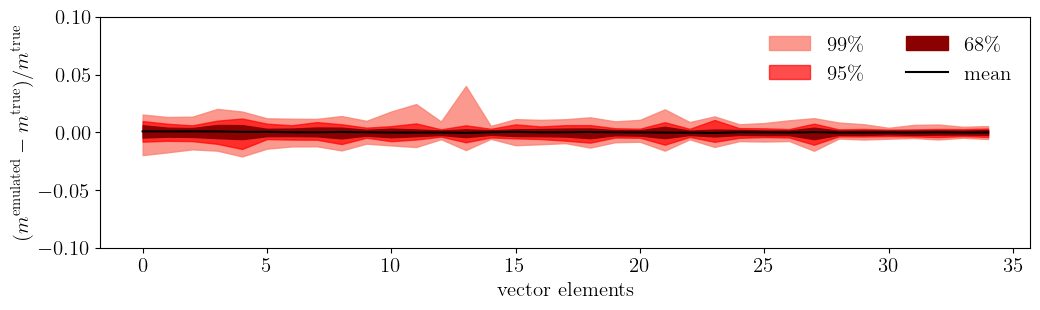

In [76]:
jax_nn = EmulatorJAX(filepath=f'outputs/Map3_env.npz')
emulated_features = jax_nn.ten_to_rescaled_predict(test_params)

diff=(emulated_features/Map3_models_test_features-1) # Measure the relative difference between test sample and the emulated models

mean_diff = np.percentile(diff, 50, axis = 0) #
mean_diff = np.median(diff, axis = 0) #
percentiles1 = np.percentile(diff, [16,84], axis = 0)
percentiles2 = np.percentile(diff, [5,95], axis = 0)
percentiles3 = np.percentile(diff, [1,99], axis = 0)
bins=range(diff.shape[1])

plt.figure(figsize=(12, 3),dpi=100)
plt.fill_between(bins, percentiles3[0,:], percentiles3[1,:], color = 'salmon', label = r'$99\%$', alpha=0.8)
plt.fill_between(bins, percentiles2[0,:], percentiles2[1,:], color = 'red', label = r'$95\%$', alpha = 0.7)
plt.fill_between(bins, percentiles1[0,:], percentiles1[1,:], color = 'darkred', label = r'$68\%$', alpha = 1)
plt.plot(bins,mean_diff,'-',color='black',label = 'mean')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon=False, fontsize=15, loc='upper right',ncol=2)
plt.ylabel(r'$(m^{\mathrm{emulated}} - m^{\mathrm{true}})/  m^{\mathrm{true}}$', fontsize=15)
plt.xlabel(r'vector elements',  fontsize=15)
plt.ylim(-0.1,0.1)
plt.show()




### Okat, now we need to download the covariance matrix. 

In [78]:
# Download the covariance matrix and parameters
gdown.download(id='1H1H_tH43rOIeOUW6cY5cx8LjpscgaMeD',output='outputs/covariance_matrix_T17.npy')

# Load the precomputed covariance matrix for the summary statistic
cov = np.load('outputs/covariance_matrix_T17.npy')

# Dimensions
ns = 570 # Number realizations used to compute the covariance matrix
nd = 40 # dimensions of the summary statistic
ndim = 8 # number of parameters in the emulator

# Hartlap correction-inspired term
B = (ns - nd - 2) / ((ns - nd - 1) * (ns - nd - 4))
m = ndim + 2 + (ns - 1 + B * (nd - ndim)) / (1 + B * (nd - ndim))

# Inverse covariance (use Cholesky solve instead of explicit inverse)
inv_cov = cho_factor(cov)


Downloading...
From: https://drive.google.com/uc?id=1H1H_tH43rOIeOUW6cY5cx8LjpscgaMeD
To: /Users/pierreburger/GitHub/cosmoemuJAX/outputs/covariance_matrix_T17.npy
100%|██████████| 6.53k/6.53k [00:00<00:00, 16.5MB/s]


### Test the models and bulit the reference data vector.

In [77]:
from cosmoemu_jax import EmulatorJAX
# --- Step 3: Restore pretrained emulator for the Map23 statistic ---
Map2_emu = EmulatorJAX(filepath=f'outputs/Map2_env.npz')
Map3_emu = EmulatorJAX(filepath=f'outputs/Map3_env.npz')


priors_params = { 
                'M1_z0_cen': [9.000497821926116, 12.997892823056496], 
                'M_c': [10.009180624129629, 15.99716430647626], 
                'beta': [-0.9967784660541272, 0.6992383181501483], 
                'eta': [-0.6977833279473113, 0.1991947243758576], 
                'theta_inn': [-1.9998000600318366, -0.00020501523840121827],
                'Omega_m': [0.23008603805291986, 0.39969071100893877],
                'Omega_b': [0.04000982924130305, 0.059994733919925755],
                'sigma8': [0.7300666536240268, 0.8999825383034264],
            }

para_names_varying = priors_params.keys()

param_dict_emu_true = {name: jnp.asarray([priors_params[name][1]/2+priors_params[name][0]/2], dtype=jnp.float32) for name in para_names_varying}
print(param_dict_emu_true)

Map2_model = Map2_emu.ten_to_rescaled_predict(param_dict_emu_true)
Map3_model = Map3_emu.ten_to_rescaled_predict(param_dict_emu_true)
data = jnp.concatenate((Map2_model, Map3_model))
data


Loading model from outputs/Map2_env.npz
Loaded keys: KeysView(NpzFile 'outputs/Map2_env.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)
Loading model from outputs/Map3_env.npz
Loaded keys: KeysView(NpzFile 'outputs/Map3_env.npz' with keys: weights, hyper_params, parameters, n_parameters, parameters_subtraction...)
{'M1_z0_cen': Array([10.999195], dtype=float32), 'M_c': Array([13.003173], dtype=float32), 'beta': Array([-0.14877008], dtype=float32), 'eta': Array([-0.2492943], dtype=float32), 'theta_inn': Array([-1.0000025], dtype=float32), 'Omega_m': Array([0.3148884], dtype=float32), 'Omega_b': Array([0.05000228], dtype=float32), 'sigma8': Array([0.8150246], dtype=float32)}


Array([1.03710308e-05, 6.90140132e-06, 4.09891572e-06, 2.42672331e-06,
       1.48867719e-06, 6.35834070e-08, 4.05017104e-08, 1.98161807e-08,
       8.78762485e-09, 3.87104881e-09, 2.60233559e-08, 1.19957964e-08,
       5.16743404e-09, 2.31068076e-09, 4.27279945e-09, 1.50338642e-09,
       6.25428764e-10, 3.79149684e-10, 1.23945632e-10, 2.77798791e-11,
       2.57024819e-08, 1.49760204e-08, 7.14860571e-09, 3.24354343e-09,
       8.60580585e-09, 3.77727805e-09, 1.65032810e-09, 1.21111976e-09,
       4.32222036e-10, 1.06102904e-10, 7.83510590e-09, 4.40088854e-09,
       2.11968376e-09, 2.37600761e-09, 1.06513298e-09, 3.39031497e-10,
       2.09616946e-09, 1.21267663e-09, 6.59818700e-10, 5.81085791e-10],      dtype=float32)

### Finally we running an HMC using the models above and using the sampler software blackjax.

In [79]:
# --- Step 3: Define the log-prior function for the parameters ---
def cal_logprior(para_dict):
    violations = [
        (para_dict[name][0] < priors_params[name][0]) | (para_dict[name][0] > priors_params[name][1])
        for name in para_names_varying
    ]
    any_violation = jnp.any(jnp.array(violations))
    return jnp.where(any_violation, -jnp.inf, 0.0)
        

def calc_likelihood(Omega_m, Omega_b, sigma8, M1_z0_cen, M_c, beta, eta, theta_inn):
    
    param_dict_emu = {
        'Omega_m': jnp.asarray([Omega_m], dtype=jnp.float32),
        'Omega_b': jnp.asarray([Omega_b], dtype=jnp.float32),
        'sigma8': jnp.asarray([sigma8], dtype=jnp.float32),
        'M1_z0_cen': jnp.asarray([M1_z0_cen], dtype=jnp.float32),
        'M_c': jnp.asarray([M_c], dtype=jnp.float32),
        'beta': jnp.asarray([beta], dtype=jnp.float32),
        'eta': jnp.asarray([eta], dtype=jnp.float32),
        'theta_inn': jnp.asarray([theta_inn], dtype=jnp.float32)
    } 
    
    # Get model prediction

    Map2_model = Map2_emu.ten_to_rescaled_predict(param_dict_emu)
    Map3_model = Map3_emu.ten_to_rescaled_predict(param_dict_emu)
    model = jnp.concatenate((Map2_model, Map3_model))
    
    delta = model - data

    # Use Cholesky solve for chi2 computation
    chi2 = jnp.dot(delta, cho_solve(inv_cov, delta))
    likelihood = -0.5 * m * jnp.log1p(chi2 / (ns - 1))
    
    # likelihood = - jnp.log1p(10)
    
    logprior = cal_logprior(param_dict_emu)

    return likelihood + logprior


logdensity = lambda x: calc_likelihood(**x)

### First, we use user defined hyper parameters for the inverse of the mass matrix, step_size for the leapfrog and so on.

In [80]:
# --- Step 4: Define the inverse mass matrix for HMC (diagonal elements) ---
inv_mass_matrix = np.array([1]*8)# this can be optimised which would improve the performance of HMC
 
print('inv_mass_matrix', inv_mass_matrix)
   
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)


initial_position = {name: jnp.asarray(priors_params[name][1]/2+priors_params[name][0]/2, dtype=jnp.float32) for name in para_names_varying}
print(initial_position)
initial_state = hmc.init(initial_position)


def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# --- Step 5: Run the MCMC sampling ---
nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)
rng_key = jax.random.key(0)
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, nuts.step, initial_state, 200_000)

mcmc_samples = states.position
mcmc_samples

np.save('outputs/mcmc_samples_Map23_HMC', mcmc_samples)

inv_mass_matrix [1 1 1 1 1 1 1 1]
{'M1_z0_cen': Array(10.999195, dtype=float32), 'M_c': Array(13.003173, dtype=float32), 'beta': Array(-0.14877008, dtype=float32), 'eta': Array(-0.2492943, dtype=float32), 'theta_inn': Array(-1.0000025, dtype=float32), 'Omega_m': Array(0.3148884, dtype=float32), 'Omega_b': Array(0.05000228, dtype=float32), 'sigma8': Array(0.8150246, dtype=float32)}


### Now, we make use of the warm up phase, which makes the posterior estimation ~8 times faster.

In [81]:
# --- Step 4: Define the inverse mass matrix for HMC (diagonal elements) ---
initial_position = {name: jnp.asarray(priors_params[name][1]/2+priors_params[name][0]/2, dtype=jnp.float32) for name in para_names_varying}
print(initial_position)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# --- Step 5: Run the MCMC sampling ---

warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=10_000)

kernel = blackjax.nuts(logdensity, **parameters).step
states = inference_loop(sample_key, kernel, state, 200_000)

mcmc_samples = states.position
mcmc_samples

np.save('outputs/mcmc_samples_Map23_HMC_warmup', mcmc_samples)

{'M1_z0_cen': Array(10.999195, dtype=float32), 'M_c': Array(13.003173, dtype=float32), 'beta': Array(-0.14877008, dtype=float32), 'eta': Array(-0.2492943, dtype=float32), 'theta_inn': Array(-1.0000025, dtype=float32), 'Omega_m': Array(0.3148884, dtype=float32), 'Omega_b': Array(0.05000228, dtype=float32), 'sigma8': Array(0.8150246, dtype=float32)}


### Finally, we plot the results.

Removed no burn in
Removed no burn in


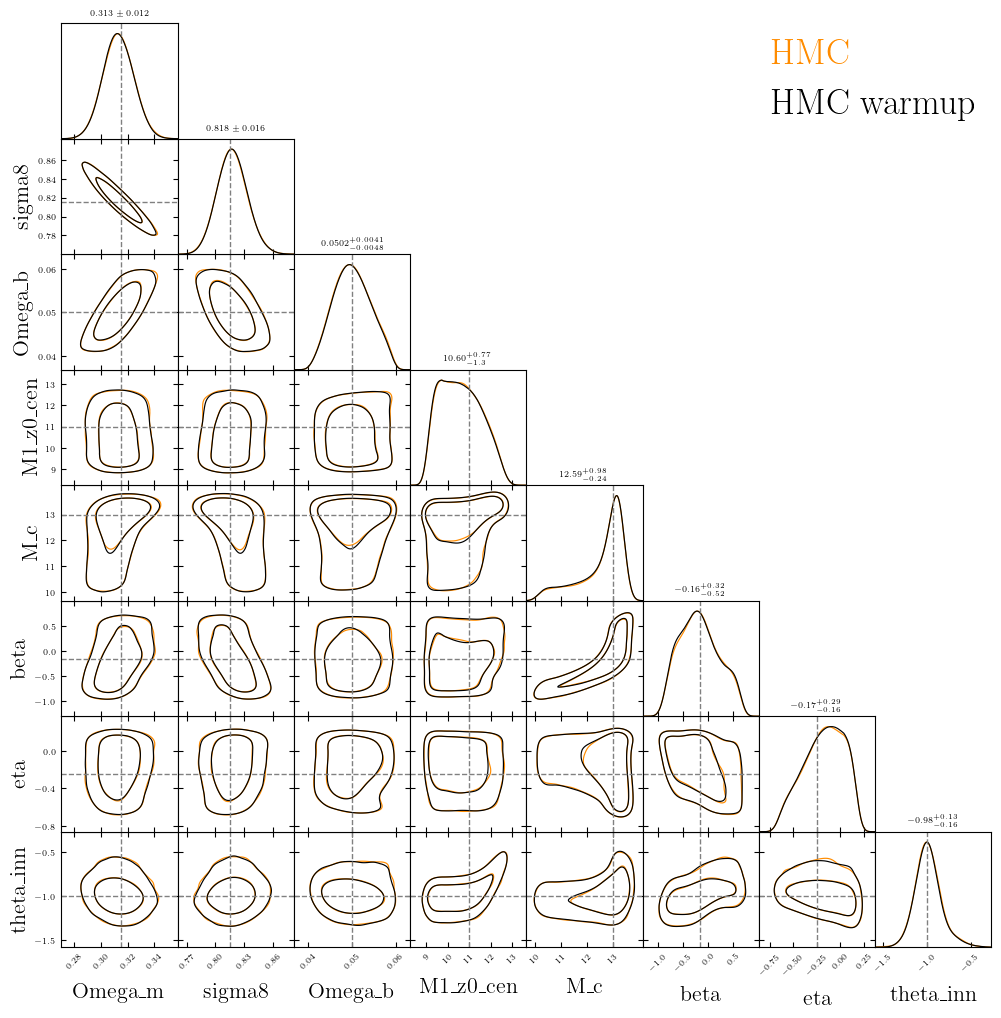

In [82]:
# --- Step 5: Import GetDist for plotting and post-processing MCMC results ---
from getdist import plots, MCSamples, parampriors
import getdist
import numpy as np

from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)  # Adjust width & height
plt.rcParams["figure.dpi"] = 100  # Lower DPI for smaller display



para_names_latex = [r'$\Omega_\mathrm{m}$', r'$\sigma_8$', r'$\Omega_\mathrm{b}$', r'$\log M_1$', r'$\log M_\mathrm{c}$', r'$\log \beta$', r'$\log \eta$', r'$\log \theta_\mathrm{inn}$']


priors_params = { 
                'M1_z0_cen': [9.000497821926116, 12.997892823056496], 
                'M_c': [10.009180624129629, 15.99716430647626], 
                'beta': [-0.9967784660541272, 0.6992383181501483], 
                'eta': [-0.6977833279473113, 0.1991947243758576], 
                'theta_inn': [-1.9998000600318366, -0.00020501523840121827],
                'Omega_m': [0.23008603805291986, 0.39969071100893877],
                'Omega_b': [0.04000982924130305, 0.059994733919925755],
                'sigma8': [0.7300666536240268, 0.8999825383034264],
            }

para_names = list(priors_params.keys())




mcmc_samples = np.load('outputs/mcmc_samples_Map23_HMC.npy',allow_pickle=True).item()
names = ['Omega_m', 'sigma8', 'Omega_b', 'M1_z0_cen', 'M_c', 'beta', 'eta', 'theta_inn']
samples_HMC = np.array([mcmc_samples[names[0]],mcmc_samples[names[1]],mcmc_samples[names[2]],mcmc_samples[names[3]],mcmc_samples[names[4]],mcmc_samples[names[5]],mcmc_samples[names[6]],mcmc_samples[names[7]]]).T[5_000:]
samples_HMC = MCSamples(samples=samples_HMC,names = names, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

mcmc_samples = np.load('outputs/mcmc_samples_Map23_HMC_warmup.npy',allow_pickle=True).item()
names = ['Omega_m', 'sigma8', 'Omega_b', 'M1_z0_cen', 'M_c', 'beta', 'eta', 'theta_inn']
samples_HMC_warmup = np.array([mcmc_samples[names[0]],mcmc_samples[names[1]],mcmc_samples[names[2]],mcmc_samples[names[3]],mcmc_samples[names[4]],mcmc_samples[names[5]],mcmc_samples[names[6]],mcmc_samples[names[7]]]).T[5_000:]
samples_HMC_warmup = MCSamples(samples=samples_HMC_warmup,names = names, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

para_truth = {name: jnp.asarray(priors_params[name][1]/2+priors_params[name][0]/2, dtype=jnp.float32) for name in para_names_varying}


colors = ['black','C2','C0']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['darkorange', 'blue', 'green','darkorange']

# retro = ['black','#e770a2','#4165c0','#5ac3be', '#696969', '#f79a1e', '#ba7dcd']


g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
# g.settings.axis_marker_ls = '-' 
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'grey'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 30
g.settings.axes_fontsize = 10
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()

contour_colors = ['darkorange', 'black', 'C0'] 


g.triangle_plot(
    
    roots=[samples_HMC, samples_HMC_warmup],
    legend_labels = ['HMC', 'HMC warmup'],
    filled=[False, False],
    contour_colors=contour_colors,
    legend_loc='upper right',
    
    title_limit=1,
    markers=para_truth,
)

